# Exploring Community Engagement with Questions on the 20 Largest StackExchange datasets

### The aim of the project is to explore how the top 20 largest Stack Exchange communities interact with questions. Firstly, I will perform EDA on all questions, answers and comments of the 20 large datasets. The second goal is to build a classification model on various different communities to identify questions with high potential of positive community engagement.

### The classification model will use only the question text and title as input, deriving features using sentiment analysis and LDA. Positive community engagement will be summarised by PCA using the score of the question, the number of answers and the sentiment of the answers.

### I will then test the individual models across all 20 communities to compare results. In this way I should gain insight into the degree to which StackExchange communities engage with questions homogenously.

---

### Load Libraries

In [1]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

import graphframes
from graphframes import *
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql.functions import col, lit, when
from pyspark.sql import Row

from datetime import datetime

import re
import numpy as np

sc.setCheckpointDir("gs://bucket-brad-project/tmp/") # change where to store if you want to

In [2]:
sc.defaultParallelism

2

In [3]:
import nltk
#nltk.download('all') # uncomment this for first run to check that all data has already been installed
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer()

# function to tokenise and lemmatise

def get_tokens(line):
    ###
    import nltk
#     nltk.download('all')
    ###
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words, see https://en.wikipedia.org/wiki/Lemmatisation
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

In [4]:
#!!!!! MAKE FUNCTION TO LOOP THROUGH ALL DATASETS

fpath = 'gs://bucket-brad-project/datasets/woodworking.stackexchange.com/'

def load_xml(table_name):
    xml_name = table_name.capitalize()
    table = sqlContext.read.format('com.databricks.spark.xml').options(rowTag=table_name).load(fpath+xml_name+'.xml')
    rdd_table = table.rdd.flatMap(lambda x: x).flatMap(lambda x: x)
    df = sqlContext.createDataFrame(rdd_table, table.schema.fields[0].dataType.elementType)
    df.createOrReplaceTempView(table_name)
    return df

In [5]:
posts = load_xml("posts")

In [6]:
# schema of the dataframe
print(type(posts))
print('\n')
posts.printSchema()

<class 'pyspark.sql.dataframe.DataFrame'>


root
 |-- _AcceptedAnswerId: long (nullable = true)
 |-- _AnswerCount: long (nullable = true)
 |-- _Body: string (nullable = true)
 |-- _ClosedDate: string (nullable = true)
 |-- _CommentCount: long (nullable = true)
 |-- _CommunityOwnedDate: string (nullable = true)
 |-- _CreationDate: string (nullable = true)
 |-- _FavoriteCount: long (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _LastActivityDate: string (nullable = true)
 |-- _LastEditDate: string (nullable = true)
 |-- _LastEditorDisplayName: string (nullable = true)
 |-- _LastEditorUserId: long (nullable = true)
 |-- _OwnerDisplayName: string (nullable = true)
 |-- _OwnerUserId: long (nullable = true)
 |-- _ParentId: long (nullable = true)
 |-- _PostTypeId: long (nullable = true)
 |-- _Score: long (nullable = true)
 |-- _Tags: string (nullable = true)
 |-- _Title: string (nullable = true)
 |-- _VALUE: string (nullable = true)
 |-- _ViewCount: long (nullable = true)



In [7]:
# total number of posts
posts.count()

7789

In [8]:
# have a look at all data from a post
posts.take(1)

[Row(_AcceptedAnswerId=None, _AnswerCount=4, _Body='<p>I\'m getting started with woodworking and am looking to refine my technique for sharpening chisel/plane blades. Currently, I just have a cheap double-sided water stone, but am now looking to get a "proper" setup which will hold me moving forward and then also refining my technique. Any suggestions?</p>\n\n<p>Edit:\nSpecifically, what type of water stones and diamond stone do I need, should I get a honing guide, what else is must have vs a nice to have, etc. Then what process do I go through to "correctly" use these tools.</p>\n', _ClosedDate=None, _CommentCount=3, _CommunityOwnedDate=None, _CreationDate='2015-03-17T15:21:33.900', _FavoriteCount=4, _Id=1, _LastActivityDate='2015-12-07T03:25:27.643', _LastEditDate='2015-12-02T22:25:12.907', _LastEditorDisplayName=None, _LastEditorUserId=878, _OwnerDisplayName=None, _OwnerUserId=19, _ParentId=None, _PostTypeId=1, _Score=21, _Tags='<technique><sharpening><plane><chisel>', _Title='How d

In [9]:
# have a look at just the body of the above post
posts.select("_Body").take(1)

[Row(_Body='<p>I\'m getting started with woodworking and am looking to refine my technique for sharpening chisel/plane blades. Currently, I just have a cheap double-sided water stone, but am now looking to get a "proper" setup which will hold me moving forward and then also refining my technique. Any suggestions?</p>\n\n<p>Edit:\nSpecifically, what type of water stones and diamond stone do I need, should I get a honing guide, what else is must have vs a nice to have, etc. Then what process do I go through to "correctly" use these tools.</p>\n')]

In [10]:
body = posts.select("_Body").rdd.flatMap(lambda r: r)

In [11]:
body.take(1)

['<p>I\'m getting started with woodworking and am looking to refine my technique for sharpening chisel/plane blades. Currently, I just have a cheap double-sided water stone, but am now looking to get a "proper" setup which will hold me moving forward and then also refining my technique. Any suggestions?</p>\n\n<p>Edit:\nSpecifically, what type of water stones and diamond stone do I need, should I get a honing guide, what else is must have vs a nice to have, etc. Then what process do I go through to "correctly" use these tools.</p>\n']

In [13]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer()

def get_tokens(line):
    ###
    import nltk
#     nltk.download('all')
    ###
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words, see https://en.wikipedia.org/wiki/Lemmatisation
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

body_rdd = body.map(lambda line: (1, get_tokens(line)))

In [14]:
body_rdd.take(1)[0][1][:10]

['p',
 'getting',
 'started',
 'woodworking',
 'looking',
 'refine',
 'technique',
 'sharpening',
 'chiselplane',
 'blade']

In [15]:
doc_stop_words = body_rdd.flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)

#doc_stop_words.collect()

[('p', 67334),
 ('getting', 494),
 ('started', 194),
 ('woodworking', 789),
 ('looking', 702),
 ('refine', 20),
 ('technique', 505),
 ('sharpening', 426),
 ('chiselplane', 2),
 ('blade', 2592),
 ('currently', 155),
 ('cheap', 370),
 ('doublesided', 18),
 ('water', 974),
 ('stone', 422),
 ('get', 2938),
 ('proper', 209),
 ('setup', 188),
 ('hold', 748),
 ('moving', 195),
 ('forward', 79),
 ('also', 2798),
 ('refining', 5),
 ('suggestion', 215),
 ('edit', 185),
 ('specifically', 227),
 ('type', 1249),
 ('diamond', 148),
 ('need', 3221),
 ('honing', 136),
 ('guide', 586),
 ('else', 240),
 ('must', 363),
 ('v', 185),
 ('nice', 441),
 ('etc', 560),
 ('process', 585),
 ('go', 1488),
 ('correctly', 131),
 ('use', 5477),
 ('tool', 2542),
 ('bought', 268),
 ('fake', 8),
 ('butcher', 61),
 ('block', 686),
 ('counter', 63),
 ('ikea', 77),
 ('really', 1179),
 ('veneer', 313),
 ('particle', 164),
 ('board', 3424),
 ('matter', 446),
 ('cut', 4051),
 ('ca', 723),
 ('nt', 6902),
 ('seem', 375),
 ('avo

In [16]:
doc_stop_words = doc_stop_words.filter(lambda a: a[1]>3000).map(lambda r: r[0]).collect()

# throw away stop words and words that are just single letters.
body_rdd = body_rdd.map(lambda r: (r[0],[w for w in r[1] if not w in doc_stop_words and not len(w)==1]))  

In [17]:
body_rdd.take(1)[0][1][:10]

['getting',
 'started',
 'woodworking',
 'looking',
 'refine',
 'technique',
 'sharpening',
 'chiselplane',
 'blade',
 'currently']

## Convert tokens into sparse vectors

In [19]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

body_df = spark.createDataFrame(body_rdd, ["dummy","words"])
body_df.cache()
body_df.take(1)

[Row(dummy=1, words=['getting', 'started', 'woodworking', 'looking', 'refine', 'technique', 'sharpening', 'chiselplane', 'blade', 'currently', 'cheap', 'doublesided', 'water', 'stone', 'looking', 'get', 'proper', 'setup', 'hold', 'moving', 'forward', 'also', 'refining', 'technique', 'suggestion', 'edit', 'specifically', 'type', 'water', 'stone', 'diamond', 'stone', 'get', 'honing', 'guide', 'else', 'must', 'nice', 'etc', 'process', 'go', 'correctly', 'tool'])]

## Now, we generate vectors that are histograms of word counts associated with each message

In [20]:
cntvcr = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

cntvcr_model = cntvcr.fit(body_df)

cntvcr_df_w_features = cntvcr_model.transform(body_df)
cntvcr_df_w_features.cache()
cntvcr_df_w_features.show(10)

+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|    1|[getting, started...|(11827,[1,5,7,8,3...|
|    1|[bought, fake, bu...|(11827,[1,7,13,23...|
|    1|[example, spindle...|(11827,[8,44,49,7...|
|    1|[building, garden...|(11827,[3,28,132,...|
|    1|[building, floor,...|(11827,[9,10,19,2...|
|    1|[currently, worki...|(11827,[33,46,59,...|
|    1|[thing, consider,...|(11827,[7,10,23,3...|
|    1|[may, able, avoid...|(11827,[12,29,53,...|
|    1|[turned, thing, g...|(11827,[11,23,34,...|
|    1|[seems, utilize, ...|(11827,[0,2,16,23...|
+-----+--------------------+--------------------+
only showing top 10 rows



## Convert pyspark.ml vectors to pyspark.mllib vectors

In [22]:
from pyspark.mllib.linalg import Vectors
#from pyspark.ml import linalg as ml_linalg
def as_mllib_vector(v):
    return Vectors.sparse(v.size, v.indices, v.values)

features = cntvcr_df_w_features.select("features")
feature_vec = features.rdd.map(lambda r: as_mllib_vector(r[0]))

feature_vec.cache()
feature_vec.take(1)

[SparseVector(11827, {1: 2.0, 5: 1.0, 7: 1.0, 8: 1.0, 38: 1.0, 56: 1.0, 87: 2.0, 121: 1.0, 130: 1.0, 150: 2.0, 188: 1.0, 189: 1.0, 199: 1.0, 223: 2.0, 230: 1.0, 279: 1.0, 293: 1.0, 297: 3.0, 350: 1.0, 359: 1.0, 551: 1.0, 585: 1.0, 622: 1.0, 637: 1.0, 682: 1.0, 687: 1.0, 702: 1.0, 708: 1.0, 815: 1.0, 851: 1.0, 905: 1.0, 927: 1.0, 1347: 1.0, 3282: 1.0, 3517: 1.0, 6940: 1.0, 10052: 1.0})]

## Take a look at the vocabulary

In [24]:
print ("Vocabulary from CountVectorizerModel is:\n")
print(cntvcr_model.vocabulary[:100])
print("\n---\n")

M = len(cntvcr_model.vocabulary)
print("Number of terms M = ", M)

Vocabulary from CountVectorizerModel is:

['bit', 'get', 'table', 'finish', 'work', 'also', 'want', 'blade', 'tool', 'used', 'way', 'could', 'surface', 'much', 'glue', 'good', 'edge', 'joint', 'side', 'top', 'time', 'hole', 'screw', 'even', 'end', 'well', 'two', 'oil', 'might', 'may', 'image', 'look', 'think', 'grain', 'thing', 'drill', 'enough', 'first', 'go', 'hand', 'something', 'plane', 'router', 'long', 'see', 'sup', 'better', 'ul', 'take', 'many', 'made', 'coat', 'cutting', 'best', 'description', 'back', 'type', 'enter', 'material', 'know', 'plywood', 'sure', 'sanding', 'really', 'question', 'still', 'lot', 'small', 'help', 'going', 'part', 'br', 'stain', 'amp', 'problem', 'since', 'little', 'leg', 'different', 'probably', 'dry', 'flat', 'set', 'find', 'dust', 'clamp', 'another', 'water', 'varnish', 'right', 'without', 'done', 'case', 'making', 'paint', 'le', 'face', 'keep', 'point', 'angle']

---

Number of terms M =  11827


##  Latent Semantic Analysis

In [25]:
from pyspark.mllib.linalg.distributed import RowMatrix

feature_mat = RowMatrix(feature_vec)

# Here we use the dimension of latent factors to be k
k = 5
feature_svd = feature_mat.computeSVD(5, computeU=True)

U = feature_svd.U       # The U factor is a RowMatrix.
s = feature_svd.s       # The singular values are stored in a local dense vector.
V = feature_svd.V       # The V factor is a local dense matrix.

In [26]:
print("number of rows of U", U.numRows()) # this is the number of documents (N)
print("number of rows of V", V.numRows ) # this is the number of terms (M)

number of rows of U 7789
number of rows of V 11827


In [27]:
collected = U.rows.take(10)

print("U factors are:")
for vector in collected:
    print(vector)
    
print("Singular values are: \n", s)

print("V factors are: \n", V)

U factors are:
[-0.0046707650442736,-0.0003520599817581461,-0.006936075097534577,-0.0036523399375832763,-0.002438375101400353]
[-0.0040942143047159475,-0.0017505454438232896,-0.00189256546809479,-0.0042616793542857015,0.0031953402792961193]
[-0.003658299079755884,-0.0026139147751907087,-0.006244900559776943,-0.0009289863583423956,-0.009371334478478266]
[-0.0019395722739520848,0.005829314531662249,0.0004968383317417135,0.0010042527917760264,0.0016746075483397257]
[-0.006415372052034878,-0.0029587536182825096,0.004282041448057538,0.0010294910815787522,0.007833177167174906]
[-0.0027986608480541617,0.0032222688958695673,0.002298363204733552,-0.0011014373242530615,-0.00037280994346078697]
[-0.004946864032220724,-0.00395968842027978,-0.007150265326752107,-0.006252495203546361,0.00737481042296959]
[-0.0019448165808312204,0.00040497328139575385,-0.00023403017461844094,-0.0003615143223612308,-0.0004915501334531348]
[-0.002132247663003843,0.0006452889642628707,-0.0001757267007411489,-0.000665072

In [28]:
from sklearn.manifold import TSNE
import numpy as np

collected = U.rows.collect()
Uarray = np.array([[x[i] for i in range(k)] for x in collected]) # unpack strange spark vectors
t_sne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='random')
Uembedded = t_sne_model.fit_transform(Uarray)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7789 samples in 0.004s...
[t-SNE] Computed neighbors for 7789 samples in 0.362s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7789
[t-SNE] Computed conditional probabilities for sample 2000 / 7789
[t-SNE] Computed conditional probabilities for sample 3000 / 7789
[t-SNE] Computed conditional probabilities for sample 4000 / 7789
[t-SNE] Computed conditional probabilities for sample 5000 / 7789
[t-SNE] Computed conditional probabilities for sample 6000 / 7789
[t-SNE] Computed conditional probabilities for sample 7000 / 7789
[t-SNE] Computed conditional probabilities for sample 7789 / 7789
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.766830
[t-SNE] KL divergence after 1000 iterations: 1.429016


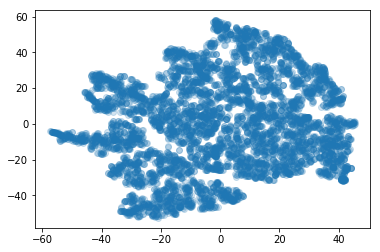

(7789, 2)

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(Uembedded[:,0],Uembedded[:,1],alpha=.2)
plt.show()
np.shape(Uembedded)

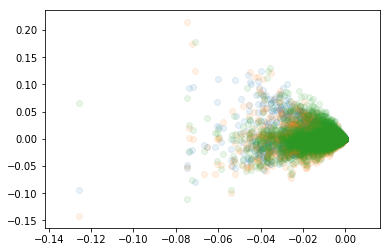

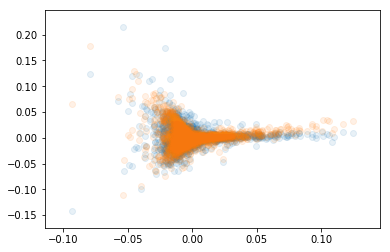

In [30]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(Uarray[:,0],Uarray[:,1],alpha=.1)
plt.scatter(Uarray[:,0],Uarray[:,2],alpha=.1)
plt.scatter(Uarray[:,0],Uarray[:,3],alpha=.1)
plt.show()
plt.scatter(Uarray[:,1],Uarray[:,2],alpha=.1)
plt.scatter(Uarray[:,1],Uarray[:,3],alpha=.1)
plt.show()

It is not true that few messages account for a large fraction of variability

## Latent Dirichlet Allocation

In [37]:
from pyspark.ml.clustering import LDA

lda = LDA(k=5, maxIter=5)

lda_model = lda.fit(cntvcr_df_w_features)

In [38]:
ll = lda_model.logLikelihood(cntvcr_df_w_features)

lp = lda_model.logPerplexity(cntvcr_df_w_features)

print("The lower bound on the log likelihood of the entire corpus: " + str(ll))

print("The upper bound on the perplexity: " + str(lp))

The lower bound on the log likelihood of the entire corpus: -4688899.687001214
The upper bound on the perplexity: 7.943073688104772


In [39]:
# describe topics
topics = lda_model.describeTopics(5)

print("The topics described by their top-weighted terms:\n")

topics.show(truncate=False)

# Shows the results
import numpy as np
topic_i = topics.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_i:
    print(np.array(cntvcr_model.vocabulary)[i])

The topics described by their top-weighted terms:

+-----+--------------------+-------------------------------------------------------------------------------------------------------------------+
|topic|termIndices         |termWeights                                                                                                        |
+-----+--------------------+-------------------------------------------------------------------------------------------------------------------+
|0    |[3, 27, 12, 14, 21] |[0.006419992770089516, 0.005236326038056644, 0.004537640650635245, 0.004056787390731613, 0.004023299210802819]     |
|1    |[0, 8, 2, 4, 5]     |[0.0062810098425910175, 0.0056088346490144195, 0.005520763614372992, 0.00470365611921883, 0.004369338951025455]    |
|2    |[22, 7, 73, 21, 856]|[0.00959797799789319, 0.0038120426283130126, 0.0036955278695335087, 0.0028049011498393352, 0.0018806711534706416]  |
|3    |[222, 9, 41, 7, 16] |[0.0024299564098441665, 0.0015569437913446184, 0.00